In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [2]:
df_merged = pd.read_pickle('data/df_merged.pkl')
df_ratings = pd.read_pickle('data/df_ratings.pkl')

# 1. Ratings

In [3]:
# Fixing the timestamp column
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s', origin='unix')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,2015-03-09 22:52:09
1,1,147,4.5,2015-03-09 23:07:15
2,1,858,5.0,2015-03-09 22:52:03
3,1,1221,5.0,2015-03-09 22:52:26
4,1,1246,5.0,2015-03-09 22:52:36


In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     Float64       
 3   timestamp  datetime64[ns]
dtypes: Float64(1), datetime64[ns](1), int64(2)
memory usage: 819.0 MB


In [5]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,2.602429e+07,2.602429e+07,26024289.0,26024289
mean,1.350371e+05,1.584911e+04,3.52809,2007-02-12 05:33:52.691320064
min,1.000000e+00,1.000000e+00,0.5,1995-01-09 11:46:44
25%,6.716400e+04,1.073000e+03,3.0,2001-05-25 01:34:21
50%,1.351630e+05,2.583000e+03,3.5,2006-07-01 00:59:27
75%,2.026930e+05,6.503000e+03,4.0,2013-01-07 16:56:19
max,2.708960e+05,1.762750e+05,5.0,2017-08-04 06:57:50
std,7.817620e+04,3.108526e+04,1.065443,NaN


- The dataset contains 26,024,289 ratings
- The ratings range from 0.5 to 5.0 with 0.5 increments, which is the typical rating scale for movie rating platforms

In [6]:
# Checking the rating distribution
df_ratings.value_counts('rating')

rating
4.0    6998802
3.0    5256722
5.0    3812499
3.5    3116213
4.5    2170441
2.0    1762440
2.5    1255358
1.0     843310
0.5     404897
1.5     403607
Name: count, dtype: int64

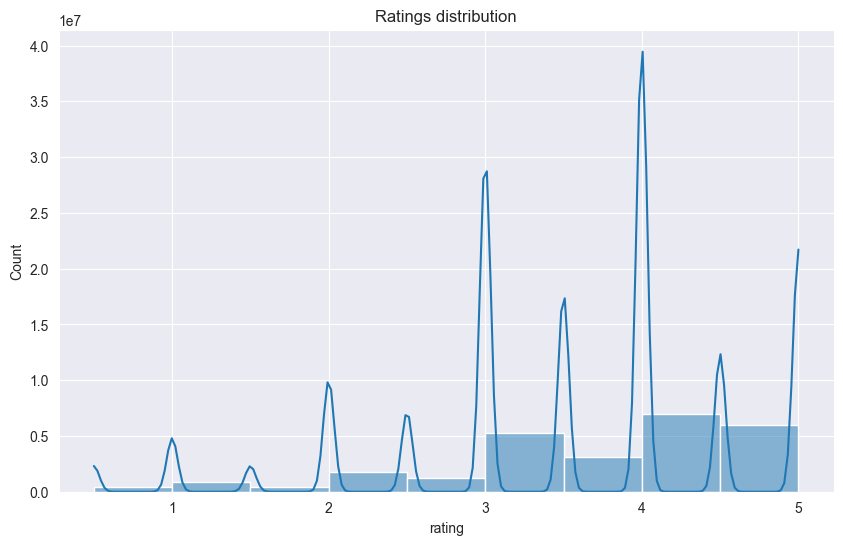

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(df_ratings['rating'], bins=9, kde=True)
plt.title('Ratings distribution')
plt.show()

- Rating scale is from 0.5 to 5.0 with 0.5 increments. 
- Most ratings are 4.0 and 3.0. 
- There are no ratings of 0
- The average rating is 3.53 which is slightly above the middle of the scale. This might be due to the fact that people are more likely to rate movies they like than movies they don't like or that people carefully select movies they watch, based on their interests.

## 1.1 Number of Ratings per User

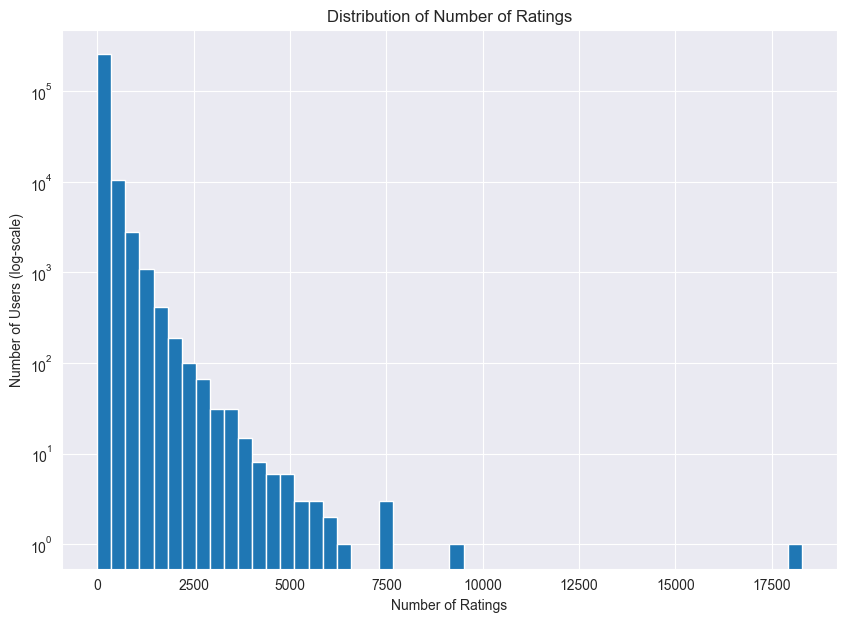

In [8]:
# Calculate and plot the distribution of ratings per user
ratings_per_user = df_ratings.groupby('userId')['rating'].count()

# Plotting the distribution of ratings per user
plt.figure(figsize=(10,7)) 
plt.hist(ratings_per_user.values, bins=50, log=True)
plt.title('Distribution of Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users (log-scale)')
plt.grid(True)
plt.show()

In [9]:
ratings_per_user.describe()

count      270896.0
mean      96.067454
std      205.719606
min             1.0
25%            15.0
50%            30.0
75%            93.0
max         18276.0
Name: rating, dtype: Float64

- The distribution of ratings per user is right-skewed
- Most users have rated less than 100 movies
- Maximum number of ratings by a user is 18276 (extremely high)
- Minimum number of ratings by a user is 1
- Average number of ratings per user is approximately 96

In [10]:
# Identify outliers using the Interquartile Range (IQR)
Q1 = ratings_per_user.quantile(0.25)
Q3 = ratings_per_user.quantile(0.75)
IQR = Q3 - Q1
outliers = ratings_per_user[(ratings_per_user < (Q1 - 1.5 * IQR)) | (ratings_per_user > (Q3 + 1.5 * IQR))]
outliers

userId
11         227
12         248
15         226
20         270
24         634
          ... 
270871     261
270872     234
270879     413
270887    2501
270896     260
Name: rating, Length: 30975, dtype: Int64

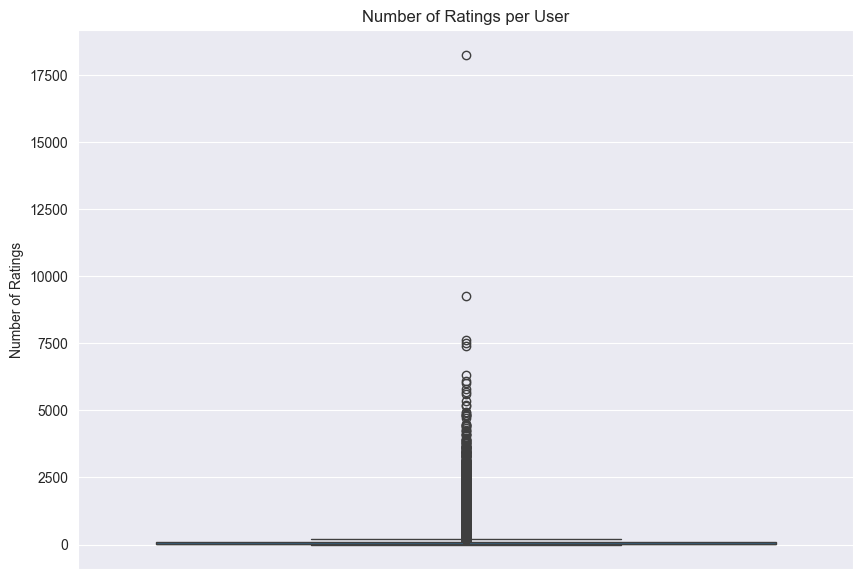

In [11]:
# Detecting outliers using boxplot
plt.figure(figsize=(10,7))
sns.boxplot(ratings_per_user, orient='v')
plt.title('Number of Ratings per User')
plt.ylabel('Number of Ratings')
plt.show()

After detecting the outliers, we can see that the distribution of ratings per user is right-skewed. Most users have rated less than 100 movies. The maximum number of ratings by a user is 18276 which could potentially be a bot, as it is extremely high. We will therefore drop this user from the dataset.

In [12]:
# Find the userId with the maximum number of ratings
user_with_max_ratings = ratings_per_user.idxmax()

# Drop rows where userId is the user with the maximum number of ratings
df_ratings = df_ratings[df_ratings['userId'] != user_with_max_ratings]

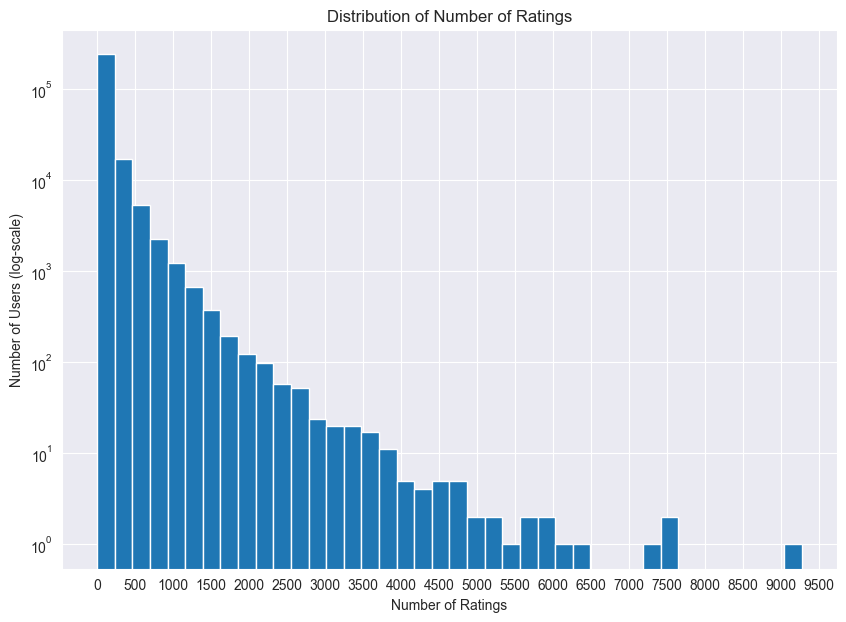

In [13]:
# Calculate and plot the distribution of ratings per user
# Group by 'userId' and count the number of ratings for each user
ratings_per_user = df_ratings.groupby('userId')['rating'].count()

# Plotting the distribution of ratings per user
plt.figure(figsize=(10,7))
plt.hist(ratings_per_user.values, bins=40, log=True)
plt.title('Distribution of Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users (log-scale)')
plt.xticks(range(0, ratings_per_user.max() + 500, 500)) 
plt.grid(True)
plt.show()

After removing the user with the maximum number of ratings, the distribution of ratings per user is still right-skewed. Most users have rated less than 100 movies. This corresponds with the typical behavior of users on movie rating platforms, where most users rate only a small fraction of the available movies.

We will now look at the distribution of ratings, below 100, to get a better understanding of the number of ratings per user.

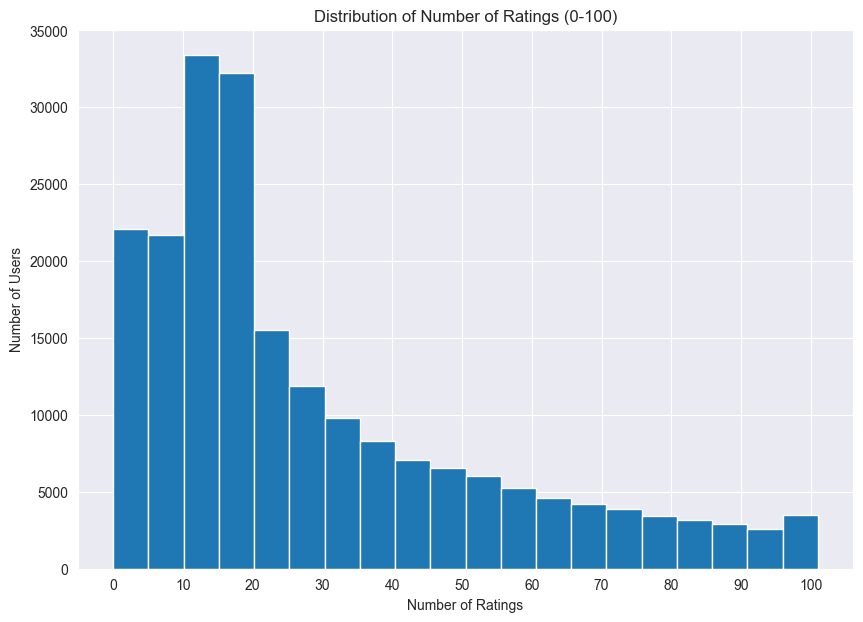

In [14]:
# Display the number of ratings for user below 100, as most users have rated less than 100 movies
ratings_per_user = df_ratings.groupby('userId')['rating'].count()

plt.figure(figsize=(10,7))
plt.hist(ratings_per_user.values, bins=(20), range=(0, 101))
plt.title('Distribution of Number of Ratings (0-100)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xticks(range(0, 101, 10))
plt.grid(True)
plt.show()

- The distribution of ratings per user is right-skewed, with many users having rated between 10-20 movies.
- However, too few ratings per user can lead to inaccurate recommendations in collaborative filtering algorithms. We will dive further into it.

In [15]:
# Number of users with 0 ratings
# Number of users with less than 20 ratings
zero_rating = ratings_per_user[ratings_per_user == 0].count()
less_than_twenty_rating = ratings_per_user[ratings_per_user < 20].count()

zero_rating, less_than_twenty_rating

(0, 104452)

- There are 0 users with 0 ratings, which is good for a movie recommender system based on ratings
- However, there are 104,452 users with less than 20 ratings.

In [16]:
# percentage users with less than 20 ratings
percentage_users_less_than_20_ratings = (less_than_twenty_rating / ratings_per_user.count()) * 100
percentage_users_less_than_20_ratings

38.55811292198084

- Over 104,000 users submitted less than 20 ratings which is 38.55% of the total number of users. This could be a challenge for collaborative filtering algorithms, as they require a minimum number of ratings to make accurate predictions. 
- We will therefore remove users with less than 20 ratings from the dataset. This will shrink our dataset but will improve the quality of recommendations. By focusing on users who have provided more ratings, we can increase the accuracy of the collaborative filtering algorithm. 
- Scalability and Adaptability: The recommendation system should be scalable and adaptable. As more users cross the threshold of 20 ratings, they should be automatically incorporated into the dataset for model training. This might happen in a later step of the project.

In [17]:
# Drop users with less than 20 ratings
df_ratings = df_ratings.groupby('userId').filter(lambda x: len(x) >= 20)

Now we want to explor the distribution of ratings per user after removing users with less than 20 ratings.

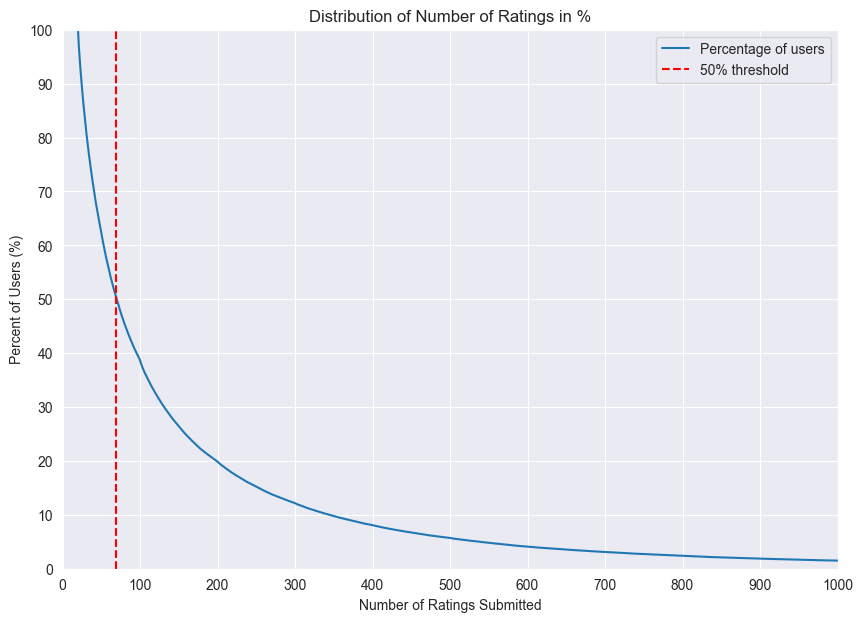

In [18]:
ratings_per_user = df_ratings.groupby('userId')['rating'].count()

max_ratings = 1000 
thresholds = np.arange(1, max_ratings + 1) 

# Calculate the cumulative percentage of users with more than 'n' ratings
percent_users = [100 * (ratings_per_user >= n).mean() for n in thresholds]

# Find the threshold where at least 50% of users have more ratings than that
fifty_percent_threshold = next(x for x, val in enumerate(percent_users) if val <= 50)

# Plot the distribution
plt.figure(figsize=(10, 7))
plt.plot(thresholds, percent_users, label='Percentage of users')
plt.axvline(x=fifty_percent_threshold, color='red', linestyle='--', label='50% threshold')
plt.xlabel('Number of Ratings Submitted')
plt.ylabel('Percent of Users (%)')
plt.title('Distribution of Number of Ratings in %')
plt.xticks(range(0, max_ratings + 1, 100)) 
plt.yticks(range(0, 101, 10))
plt.grid(True)
plt.legend()

# Adjust plot limits and ticks for better clarity
plt.xlim(0, max_ratings)
plt.ylim(0, 100)

plt.show()

- 50% of users have rated more than 70-80 movies
- Around 10% of users have even rated more than 350 movies
- We can conclude that the majority of users have rated a significant number of movies, which makes this dataset suitable for collaborative filtering algorithms.

Visualizing the distribution of ratings and some statistics on the ratings.

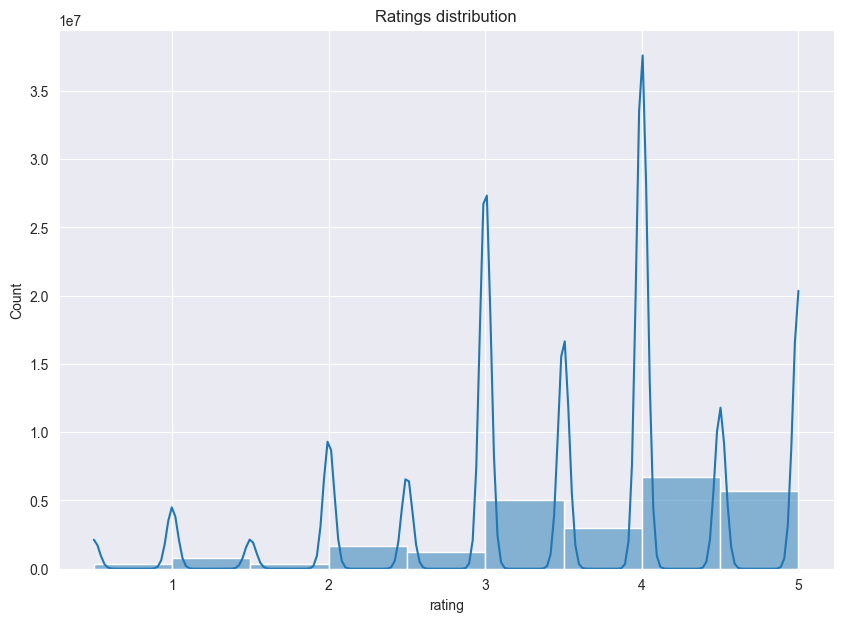

In [19]:
# Bi-model distribution of rating scores
plt.figure(figsize=(10, 7))
sns.histplot(df_ratings['rating'], bins=9, kde=True)
plt.title('Ratings distribution')
plt.show()


In [20]:
ratings_statistics = df_ratings['rating'].describe()
ratings_statistics

count    24829828.0
mean        3.52898
std        1.060177
min             0.5
25%             3.0
50%             3.5
75%             4.0
max             5.0
Name: rating, dtype: Float64

We can observe that the distribution of ratings is bimodal, with peaks at 3.0 and 4.0. The average rating is 3.53, which is slightly above the middle of the scale. The 75th percentile is 4.0, which indicates that 75% of the ratings are 4.0 or below. We come to the conclusion that a movie can be considered as "good" if it has a rating of 4.0 or above.

We will now calculate the average rating for each user and add a column to indicate if the user liked the movie based on their average rating. We say that if the rating is greater than or equal to the user's average rating, then the user liked the movie.

In [21]:
# Calculate the average rating for each user
user_mean_ratings = df_ratings.groupby('userId')['rating'].mean().reset_index(name='user_mean_rating')

# Merge the average ratings with the original dataframe
df_ratings = pd.merge(df_ratings, user_mean_ratings, on='userId')

# Add a column to indicate if the user liked the movie (rating >= user_mean_rating)
df_ratings['liked_by_user'] = df_ratings['rating'] >= df_ratings['user_mean_rating']
df_ratings.head(50)

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user
0,1,110,1.0,2015-03-09 22:52:09,4.277778,False
1,1,147,4.5,2015-03-09 23:07:15,4.277778,True
2,1,858,5.0,2015-03-09 22:52:03,4.277778,True
3,1,1221,5.0,2015-03-09 22:52:26,4.277778,True
4,1,1246,5.0,2015-03-09 22:52:36,4.277778,True
5,1,1968,4.0,2015-03-09 23:02:28,4.277778,False
6,1,2762,4.5,2015-03-09 22:48:20,4.277778,True
7,1,2918,5.0,2015-03-09 22:53:13,4.277778,True
8,1,2959,4.0,2015-03-09 22:53:21,4.277778,False
9,1,4226,4.0,2015-03-09 23:03:48,4.277778,False


- This column will be useful for content-based filtering algorithms, as it provides information about the user's preferences and can be used to recommend movies that are similar to the ones the user liked.

## 1.2 Number of Ratings over Time

In [22]:
df_ratings.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user
0,1,110,1.0,2015-03-09 22:52:09,4.277778,False
1,1,147,4.5,2015-03-09 23:07:15,4.277778,True
2,1,858,5.0,2015-03-09 22:52:03,4.277778,True
3,1,1221,5.0,2015-03-09 22:52:26,4.277778,True
4,1,1246,5.0,2015-03-09 22:52:36,4.277778,True


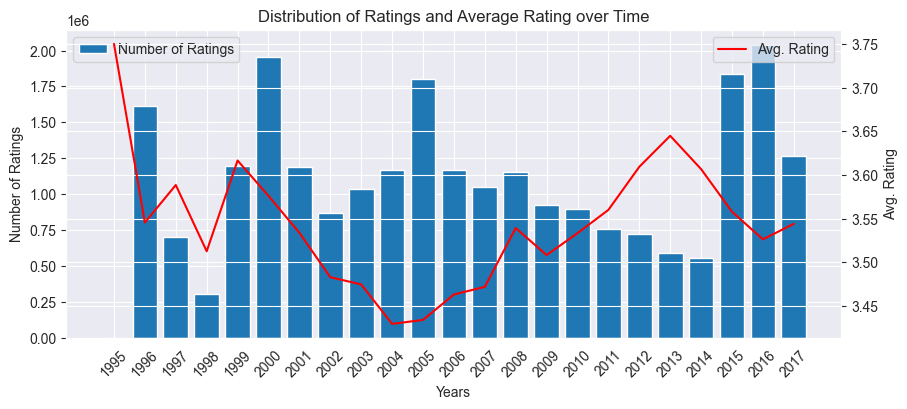

In [23]:
ratings_by_year = df_ratings.groupby(df_ratings['timestamp'].dt.strftime('%Y')).agg({'rating': ['count', 'mean']})

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

ax1.bar(ratings_by_year.index, height=ratings_by_year.iloc[:,0], label='Number of Ratings')
ax1.legend(loc='upper left')
ax1.set_xlabel('Years')
ax1.set_ylabel('Number of Ratings')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(ratings_by_year.iloc[:,1], 'r', label='Avg. Rating')
ax2.legend(loc='upper right')
ax2.set_ylabel('Avg. Rating')

plt.title('Distribution of Ratings and Average Rating over Time');

- The number of ratings seem to fluctuate over time, with a peak around 2015 and a high rate of ratings in the following years. This could be due to the increasing popularity of online movie rating platforms and the rise of streaming services.

# 2. Movies

In [24]:
df_merged.head()

,id_x,keywords,movieId,imdbId,tmdbId,belongs_to_collection,original_language,overview,popularity,release_date,runtime,title,vote_average,vote_count,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted,spoken_language_extracted
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",1,114709,862,1,en,"Led by Woody, Andy's toys live happily in his ...",21.0,1995-10-30,81.0,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America],[English]
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...",2,113497,8844,0,en,When siblings Judy and Peter discover an encha...,17.0,1995-12-15,104.0,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],"[English, Français]"
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",3,113228,15602,1,en,A family wedding reignites the ancient feud be...,11.0,1995-12-22,101.0,Grumpier Old Men,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America],[English]
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...",4,114885,31357,0,en,"Cheated on, mistreated and stepped on, the wom...",3.0,1995-12-22,127.0,Waiting to Exhale,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America],[English]
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",5,113041,11862,1,en,Just when George Banks has recovered from his ...,8.0,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America],[English]


In [25]:
df_merged.describe()

,id_x,movieId,imdbId,tmdbId,belongs_to_collection,popularity,release_date,runtime,vote_average,vote_count
count,38862.0,38862.0,38862.0,38862.0,38862.000000,38862.000000,38862,38862.000000,38862.000000,38862.000000
mean,97413.201251,91145.962251,969189.58453,97413.201251,0.108178,2.853482,1993-02-17 14:58:42.742010240,100.120426,6.004459,127.122176
min,2.0,1.0,574.0,2.0,0.000000,0.000000,1906-12-26 00:00:00,45.000000,0.500000,1.000000
25%,22519.25,33802.75,82757.0,22519.25,0.000000,0.000000,1979-12-18 00:00:00,88.000000,5.300000,4.000000
50%,50773.0,102038.0,280507.0,50773.0,0.000000,1.000000,2001-11-19 12:00:00,96.000000,6.100000,12.000000
75%,127800.0,141169.0,1512591.25,127800.0,0.000000,4.000000,2011-01-01 00:00:00,108.000000,6.800000,43.000000
max,464207.0,176273.0,7104950.0,464207.0,1.000000,547.000000,2017-09-14 00:00:00,300.000000,10.000000,14075.000000
std,107565.827641,57709.055438,1327487.328718,107565.827641,0.310609,6.365811,NaN,22.656623,1.232272,529.292963


- We dont observe any anomalies in the dataset

In [26]:
# Check for missing values
df_merged.isnull().sum()

id_x                            0
keywords                        0
movieId                         0
imdbId                          0
tmdbId                          0
belongs_to_collection           0
original_language               0
overview                        0
popularity                      0
release_date                    0
runtime                         0
title                           0
vote_average                    0
vote_count                      0
actors                          0
keywords_extracted              0
genre_extracted                 0
production_company_extracted    0
production_country_extracted    0
spoken_language_extracted       0
dtype: int64

- We dont have any missing values in the dataset, making it ready for analysis

## 2.1 Movies & Ratings per Genre

We will first transform the 'genre_extracted' column into a list of genres and then count the number of movies per genre and the popularity.

In [27]:
# Function to convert strings to lists or replace empty lists
def convert_or_replace(genre):
    if isinstance(genre, list):
        return genre if genre else ['(none)']
    elif isinstance(genre, str):
        try:
            return ast.literal_eval(genre)
        except ValueError:
            return ['(none)']
    else:
        return ['(none)']

# Apply the function to the 'genre_extracted' column
df_merged['genre_extracted'] = df_merged['genre_extracted'].apply(convert_or_replace)

df_merged.head(10)

,id_x,keywords,movieId,imdbId,tmdbId,belongs_to_collection,original_language,overview,popularity,release_date,runtime,title,vote_average,vote_count,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted,spoken_language_extracted
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",1,114709,862,1,en,"Led by Woody, Andy's toys live happily in his ...",21.0,1995-10-30,81.0,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America],[English]
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...",2,113497,8844,0,en,When siblings Judy and Peter discover an encha...,17.0,1995-12-15,104.0,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],"[English, Français]"
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",3,113228,15602,1,en,A family wedding reignites the ancient feud be...,11.0,1995-12-22,101.0,Grumpier Old Men,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America],[English]
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...",4,114885,31357,0,en,"Cheated on, mistreated and stepped on, the wom...",3.0,1995-12-22,127.0,Waiting to Exhale,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America],[English]
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",5,113041,11862,1,en,Just when George Banks has recovered from his ...,8.0,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America],[English]
5,949,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...",6,113277,949,0,en,"Obsessive master thief, Neil McCauley leads a ...",17.0,1995-12-15,170.0,Heat,7.7,1886.0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[robbery, detective, bank, obsession, chase, s...","[Action, Crime, Drama, Thriller]","[Regency Enterprises, Forward Pass, Warner Bros.]",[United States of America],"[English, Español]"
6,11860,"[{'id': 90, 'name': 'paris'}, {'id': 380, 'nam...",7,114319,11860,0,en,An ugly duckling having undergone a remarkable...,6.0,1995-12-15,127.0,Sabrina,6.2,141.0,"[Harrison Ford, Julia Ormond, Greg Kinnear, An...","[paris, brother brother relationship, chauffeu...","[Comedy, Romance]","[Paramount Pictures, Scott Rudin Productions, ...","[Germany, United States of America]","[Français, English]"
7,45325,[],8,112302,45325,0,en,"A mischievous young boy, Tom Sawyer, witnesses...",2.0,1995-12-22,97.0,Tom and Huck,5.4,45.0,"[Jonathan Taylor Thomas, Brad Renfro, Rachael ...",[],"[Action, Adventure, Drama, Family]",[Walt Disney Pictures],[United States of America],"[English, Deutsch]"
8,9091,"[{'id': 949, 'name': 'terrorist'}, {'id': 1562...",9,114576,9091,0,en,International action superstar Jean Claude Van...,5.0,1995-12-22,106.0,Sudden Death,5.5,174.0,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...","[terrorist, hostage, explosive, vice president]","[Action, Adventure, Thriller]","[Universal Pictures, Imperial Entertainment, S...",[United States of America],[English]
9,710,"[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...",10,113189,710,1,en,James Bond must unmask the mysterious head of ...,14.0,1995-11-16,130.0,GoldenEye,6.6,1194.0,"[Pierce Brosnan, Sean Bean, Izabella Scorupco,...","[cuba, falsely accused, secret identity, compu...","[Adventure, Action, Thriller]","[United

In [28]:
# print columns
df_merged.columns

Index(['id_x', 'keywords', 'movieId', 'imdbId', 'tmdbId',
       'belongs_to_collection', 'original_language', 'overview', 'popularity',
       'release_date', 'runtime', 'title', 'vote_average', 'vote_count',
       'actors', 'keywords_extracted', 'genre_extracted',
       'production_company_extracted', 'production_country_extracted',
       'spoken_language_extracted'],
      dtype='object')

In [29]:
# Drop the keyword column as it is not the updated version
df_merged.drop('keywords', axis=1, inplace=True)

In [30]:
# Flatten all the lists in the 'genre_extracted' column into a single list
all_genres = [genre for sublist in df_merged['genre_extracted'].tolist() for genre in sublist]

# Convert the flattened list into a set to remove duplicates and then count the unique elements
unique_genres_count = len(set(all_genres))

print(f'Total number of unique genres: {unique_genres_count}')

Total number of unique genres: 21


/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_49862/3993584649.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


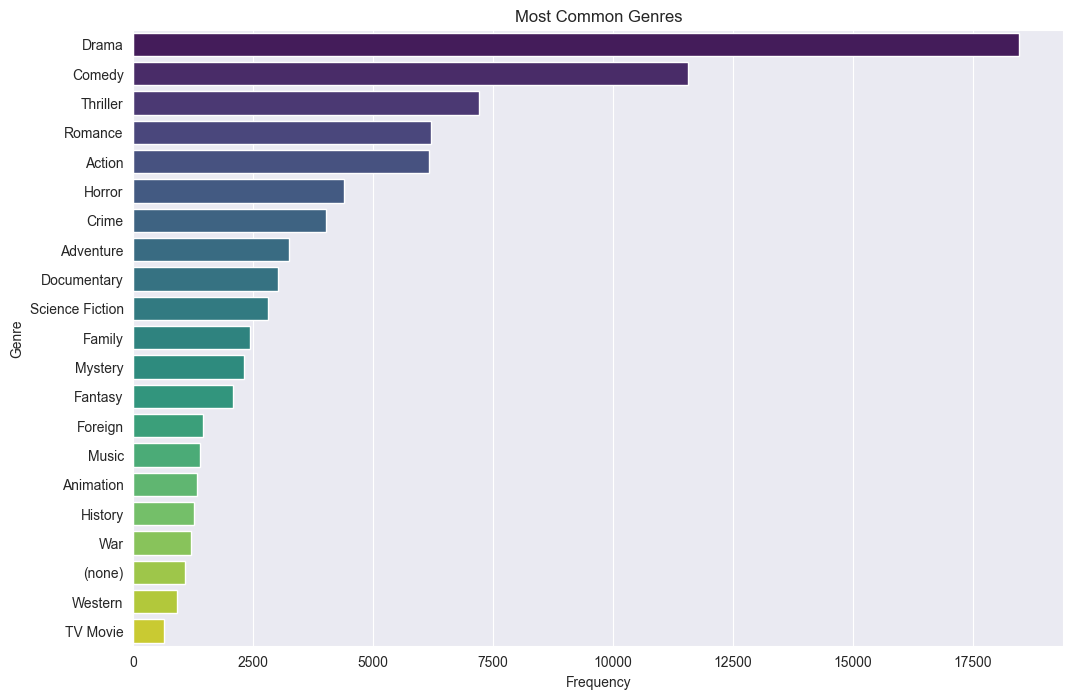

In [31]:
# Explode the 'genre_extracted' column to separate the genres
genre_counts = df_merged['genre_extracted'].explode().value_counts()

# Get the most common genres
top_genres = genre_counts

# Plot the number of movies per genre
plt.figure(figsize=(12, 8))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Most Common Genres')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.show()


- Drama is the most common genre, followed by Comedy and Thriller.
- The least common genres are none (no Genres listed for those movies), Western, and TV Movie.
- The distribution of genres is right-skewed, with a few genres being very common and most genres being less common.
- This information can be useful for content-based filtering algorithms. The data suggests that this column has a valid distribution and could be potentially used in further analysis.

This distribution could be due to the fact that some genres are more often associated with other genres and more popular in general. For example, Drama is a very broad genre that can encompass many different types of movies, while War and Western movies are more niche genres that appeal to a smaller audience.

This information can be useful for content-based filtering algorithms, as it provides insights into the distribution of genres in the dataset.

We will now explore cross-tabulation of genres to see if "Drama" is most commonly associated with the second most common genre "Comedy" and the third most common genre "Thriller".

In [32]:
# Create a new DataFrame to hold our genre presence information
genre_presence = pd.DataFrame()

# Check for presence of each genre of interest
for genre in ['Drama', 'Comedy', 'Thriller']:
    genre_presence[genre] = df_merged['genre_extracted'].apply(lambda genres: genre in genres)

# Perform cross tabulation - count movies that are Drama and also belong to each of the other genres
cross_tabulation = pd.crosstab(index=genre_presence['Drama'],
                               columns=[genre_presence['Comedy'], genre_presence['Thriller']],
                               rownames=['Drama'],
                               colnames=['Comedy', 'Thriller'])

cross_tabulation

Comedy    False       True       
Thriller  False True  False True 
Drama                            
False      9172  3538  7277   406
True      11534  3060  3666   209

- There are 11,534 movies classified as Drama, but NOT as Comedy or Thriller.
- There are 3,060 movies classified as Drama and Thriller, but not as Comedy.
- There are 3,666 movies classified as Drama and Comedy, but not as Thriller.

The cross-tabulation shows that Drama is not always associated with Comedy or Thriller, but often. This suggests that the genres are not always mutually exclusive and that movies can belong to multiple genres. This information can be useful for content-based filtering algorithms, as it provides insights into the relationships between different genres.

We will now explore the distribution of ratings for each genre to see if there are any differences in the ratings for different genres.

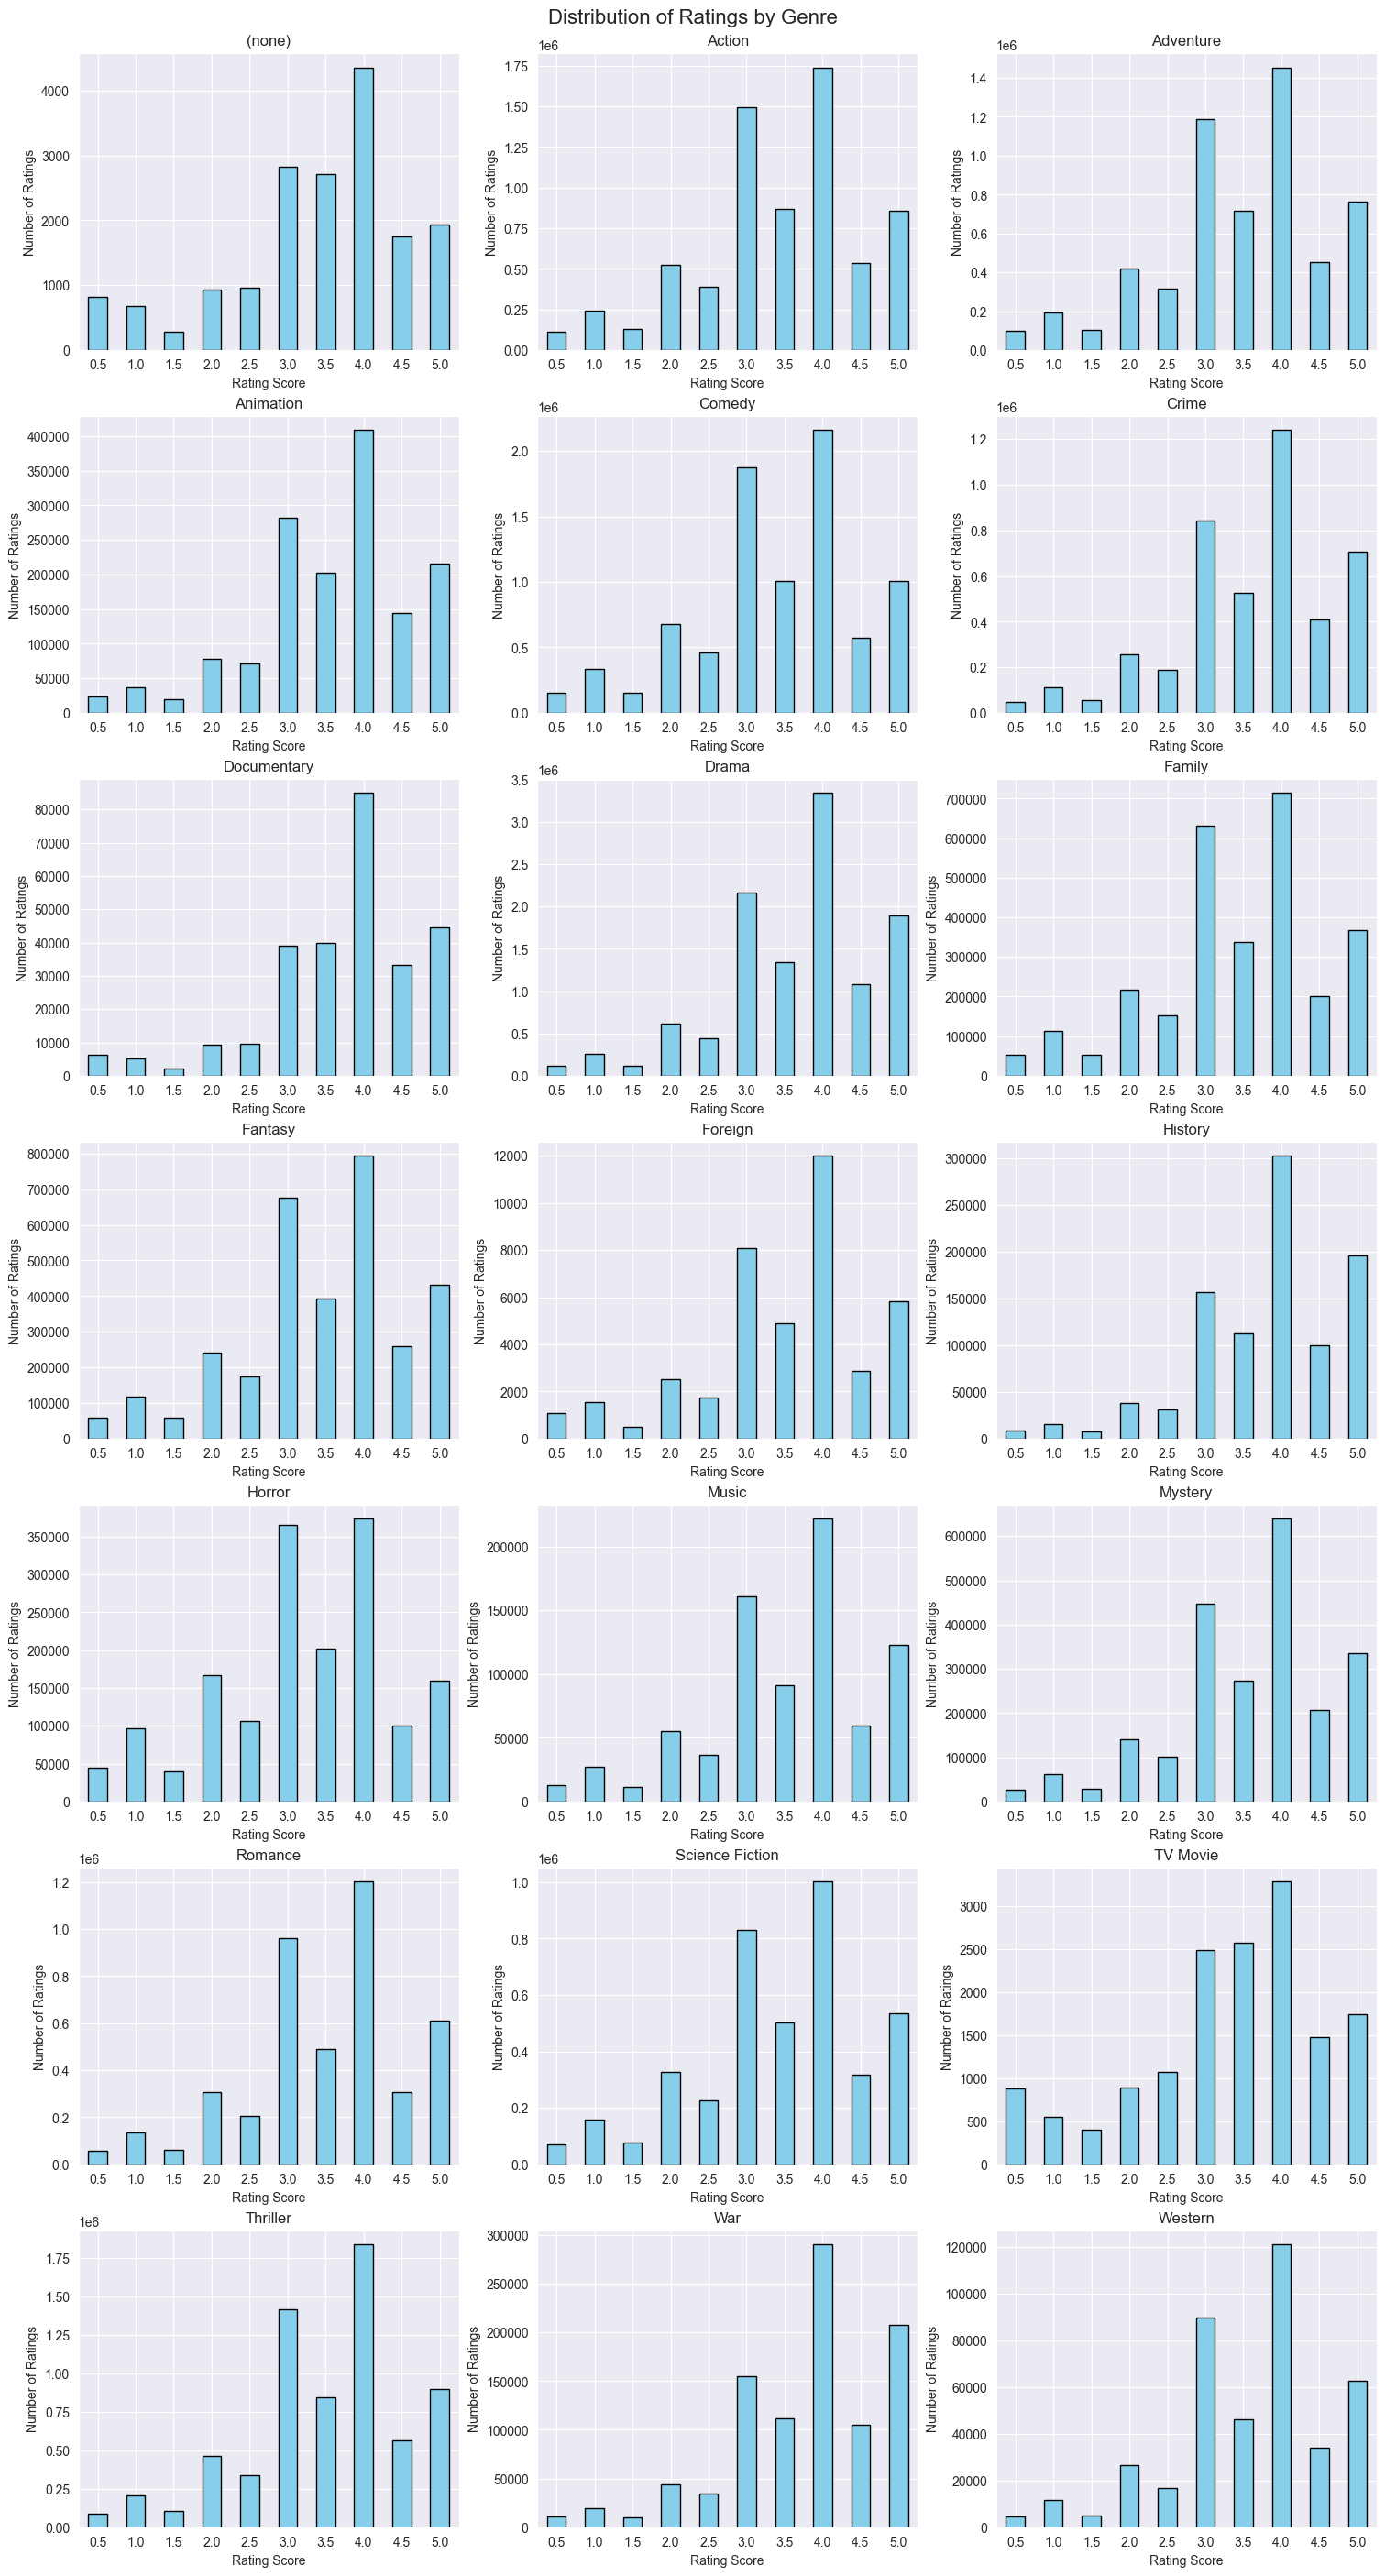

In [33]:
# Merge the ratings and movies dataframes on 'movieId'
genre_ratings = df_ratings.merge(df_merged[['movieId', 'genre_extracted']], on='movieId')

# Explode the 'genre_extracted' column to have one genre per row
genre_ratings = genre_ratings.explode('genre_extracted')

# Group the data by genre and rating to count the number of ratings for each score
rating_counts_by_genre = genre_ratings.groupby(['genre_extracted', 'rating']).size().unstack(fill_value=0)

# Get a list of unique genres for plotting
genres = rating_counts_by_genre.index.tolist()

n_cols = 3
n_rows = (len(genres) + n_cols - 1) // n_cols 
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True)
axs = axs.flatten()

# Plot the distribution for each genre
for i, genre in enumerate(genres):
    # Select the current axis
    ax = axs[i]

    # Get the ratings counts for the current genre
    data = rating_counts_by_genre.loc[genre]

    # Create a bar plot
    data.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

    # Set the title and labels
    ax.set_title(genre)
    ax.set_xlabel('Rating Score')
    ax.set_ylabel('Number of Ratings')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Hide any unused subplots if the number of genres is less than the number of subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

# Add a main title
plt.suptitle('Distribution of Ratings by Genre', fontsize=16)

# Show the plot
plt.show()

- The distribution of ratings varies across genres, with some genres having more high ratings (e.g., War) and others having more low ratings (e.g., TV Movie).
- However, the overall distribution of ratings is quite similar across genres, with most ratings being in the 3.0 to 4.0 range. So considerably high.

## 2.2 Movies per Year

In [34]:
# See the range of years in the dataset
start_year = df_merged['release_date'].min()
end_year = df_merged['release_date'].max()

print(f"The dataset starts in the year: {start_year}")
print(f"The dataset ends in the year: {end_year}")

The dataset starts in the year: 1906-12-26 00:00:00
The dataset ends in the year: 2017-09-14 00:00:00


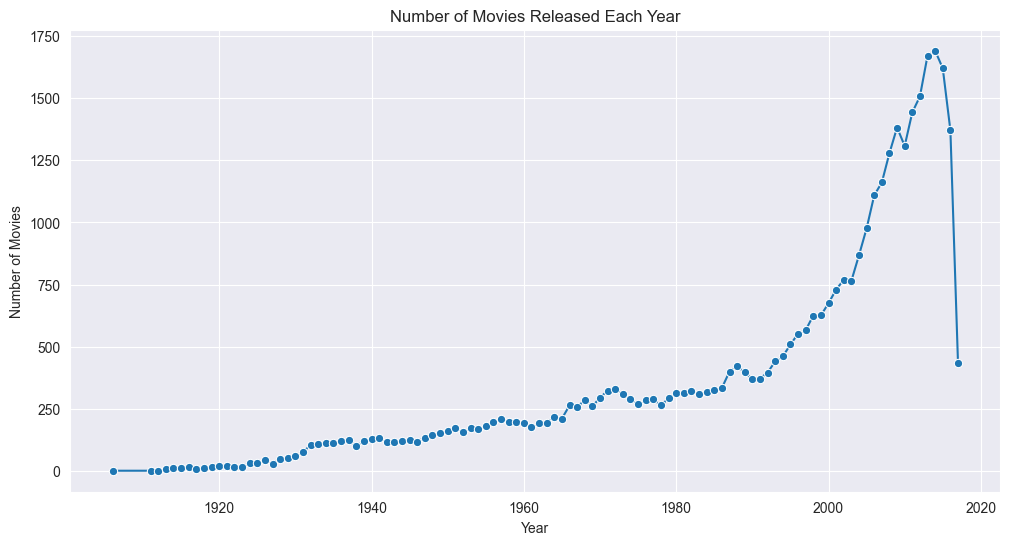

In [35]:
df_year = df_merged.copy()

# Extract the year from the 'release_date' column
df_year['year'] = pd.to_datetime(df_merged['release_date'], errors='coerce').dt.year

# Count the number of movies released each year
movies_per_year = df_year['year'].value_counts().sort_index()

# Plot the number of movies released each year
plt.figure(figsize=(12, 6))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker='o')
plt.title('Number of Movies Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

Early 20th Century (up to 1940s):
- Relatively few releases, likely due to the nascent state of the film industry and the technological limitations of the time.

Post-World War II Era (late 1940s to 1950s):
- A slight increase in movie releases could be attributed to the post-war economic boom and technological advancements in film production.

Steady growth up until late 1990s

Post-2000 to 2020s:
- The explosion in the number of releases may be linked to the rise of the internet, digital distribution, independent filmmaking, and the proliferation of digital platforms requiring content.
- Streaming services have also contributed to the increase in movie production and distribution.

The drop is due to the fact that the dataset only contains movies up until September 2017.

We will now analyze the Top 5 genres trends over time.

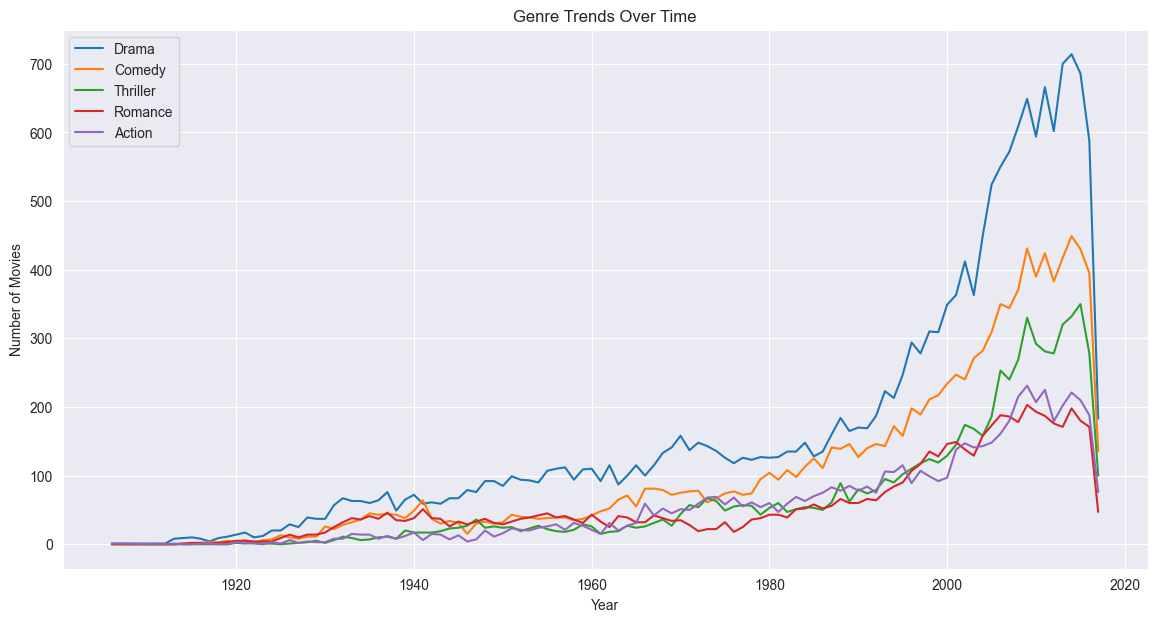

In [36]:
# Convert release_date to datetime and extract the year
df_merged['year'] = pd.to_datetime(df_merged['release_date']).dt.year

# Initialize a DataFrame to store genre counts by year
genre_trends = pd.DataFrame()

# List of genres to analyze
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action']

# Count the occurrence of each genre by year
for genre in genres:
    df_merged[genre] = df_merged['genre_extracted'].apply(lambda x: genre in x)
    genre_trends[genre] = df_merged.groupby('year')[genre].sum()

# Plotting the trends
plt.figure(figsize=(14, 7))

for genre in genres:
    plt.plot(genre_trends.index, genre_trends[genre], label=genre)

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Genre Trends Over Time')
plt.legend()
plt.show()

- Drama is the most common genre throughout the years, followed by Comedy.
- The trend for Thriller movies seems to be increasing over time, while the trend for Action also increased but now stagnates, like Romance movies.

In [37]:
# Drop the columns created for the analysis (genres, year)
df_merged.drop(['year', 'Drama', 'Comedy', 'Thriller', 'Romance', 'Action'], axis=1, inplace=True)

## 2.3 Movie Keywords

In [38]:
# Function to convert strings to lists or replace empty lists
def convert_or_replace_keywords(keyword):
    if isinstance(keyword, list):
        return keyword if keyword else ['(none)']
    elif isinstance(keyword, str):
        try:
            return ast.literal_eval(keyword)
        except ValueError:
            return ['(none)']
    else:
        return ['(none)']

# Apply the function to the 'keywords_extracted' column
df_merged['keywords_extracted'] = df_merged['keywords_extracted'].apply(convert_or_replace_keywords)

df_merged.head(10)

,id_x,movieId,imdbId,tmdbId,belongs_to_collection,original_language,overview,popularity,release_date,runtime,title,vote_average,vote_count,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted,spoken_language_extracted
0,862,1,114709,862,1,en,"Led by Woody, Andy's toys live happily in his ...",21.0,1995-10-30,81.0,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America],[English]
1,8844,2,113497,8844,0,en,When siblings Judy and Peter discover an encha...,17.0,1995-12-15,104.0,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],"[English, Français]"
2,15602,3,113228,15602,1,en,A family wedding reignites the ancient feud be...,11.0,1995-12-22,101.0,Grumpier Old Men,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America],[English]
3,31357,4,114885,31357,0,en,"Cheated on, mistreated and stepped on, the wom...",3.0,1995-12-22,127.0,Waiting to Exhale,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America],[English]
4,11862,5,113041,11862,1,en,Just when George Banks has recovered from his ...,8.0,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America],[English]
5,949,6,113277,949,0,en,"Obsessive master thief, Neil McCauley leads a ...",17.0,1995-12-15,170.0,Heat,7.7,1886.0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[robbery, detective, bank, obsession, chase, s...","[Action, Crime, Drama, Thriller]","[Regency Enterprises, Forward Pass, Warner Bros.]",[United States of America],"[English, Español]"
6,11860,7,114319,11860,0,en,An ugly duckling having undergone a remarkable...,6.0,1995-12-15,127.0,Sabrina,6.2,141.0,"[Harrison Ford, Julia Ormond, Greg Kinnear, An...","[paris, brother brother relationship, chauffeu...","[Comedy, Romance]","[Paramount Pictures, Scott Rudin Productions, ...","[Germany, United States of America]","[Français, English]"
7,45325,8,112302,45325,0,en,"A mischievous young boy, Tom Sawyer, witnesses...",2.0,1995-12-22,97.0,Tom and Huck,5.4,45.0,"[Jonathan Taylor Thomas, Brad Renfro, Rachael ...",[(none)],"[Action, Adventure, Drama, Family]",[Walt Disney Pictures],[United States of America],"[English, Deutsch]"
8,9091,9,114576,9091,0,en,International action superstar Jean Claude Van...,5.0,1995-12-22,106.0,Sudden Death,5.5,174.0,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...","[terrorist, hostage, explosive, vice president]","[Action, Adventure, Thriller]","[Universal Pictures, Imperial Entertainment, S...",[United States of America],[English]
9,710,10,113189,710,1,en,James Bond must unmask the mysterious head of ...,14.0,1995-11-16,130.0,GoldenEye,6.6,1194.0,"[Pierce Brosnan, Sean Bean, Izabella Scorupco,...","[cuba, falsely accused, secret identity, compu...","[Adventure, Action, Thriller]","[United Artists, Eon Productions]","[United Kingdom, United States of America]","[English, Pусский, Español]"


In [39]:
# Flatten all the lists in the 'keywords_extracted' column into a single list
all_keywords = [keyword for sublist in df_merged['keywords_extracted'].tolist() for keyword in sublist]

# Convert the flattened list into a set to remove duplicates and then count the unique elements
unique_keywords_count = len(set(all_keywords))

print(f'Total number of unique Keywords: {unique_keywords_count}')

Total number of unique Keywords: 19405


/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_49862/2310179303.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')


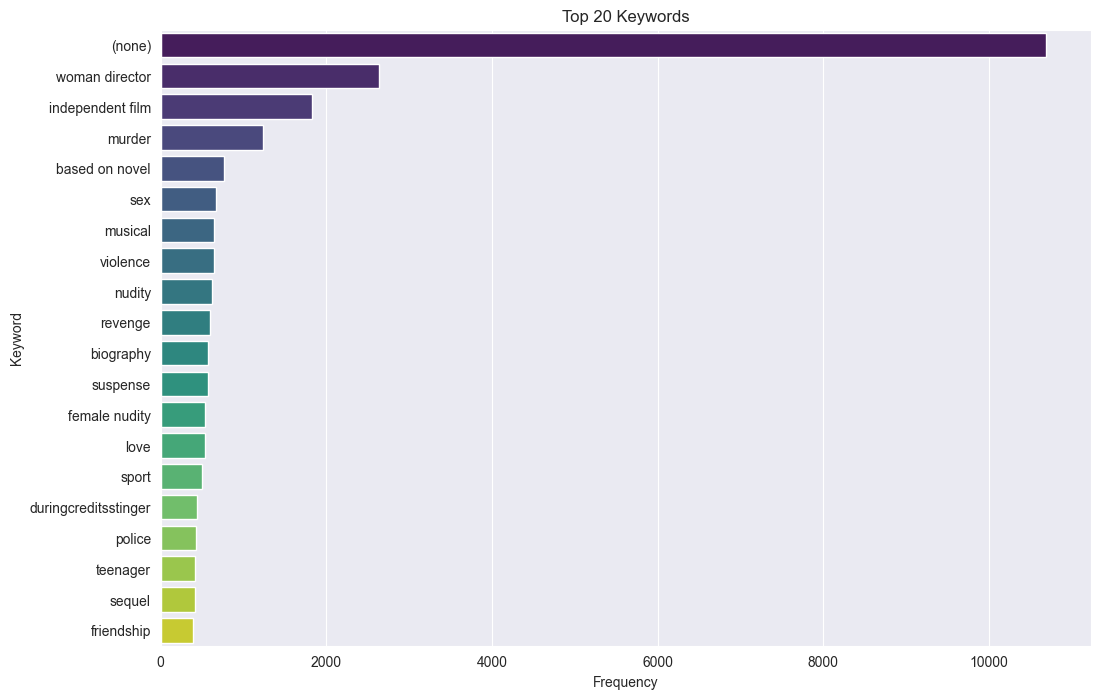

In [40]:
# Plot the top 20 keywords that were assigned to most movies
top_keywords = df_merged['keywords_extracted'].explode().value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title('Top 20 Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

In [41]:
# Most frequent keywords in percentage (including 'none')
top_keywords_percentage = top_keywords / len(df_merged) * 100
top_keywords_percentage

keywords_extracted
(none)                  27.510164
woman director           6.770110
independent film         4.703824
murder                   3.190778
based on novel           1.976224
sex                      1.713756
musical                  1.667439
violence                 1.649426
nudity                   1.587669
revenge                  1.546498
biography                1.469302
suspense                 1.456436
female nudity            1.371520
love                     1.363800
sport                    1.273738
duringcreditsstinger     1.124492
police                   1.106479
teenager                 1.078174
sequel                   1.078174
friendship               1.016417
Name: count, dtype: float64

- The most common keyword is 'none' (27.5% of movies), which indicates that many movies do not have any keywords assigned to them.
- We need to further investigate this column during Feature Engineering to see if it can be used for content-based filtering.

We will exclude the 'none' keyword and plot the top 20 keywords that were assigned to most movies.

/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_49862/2579338430.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')


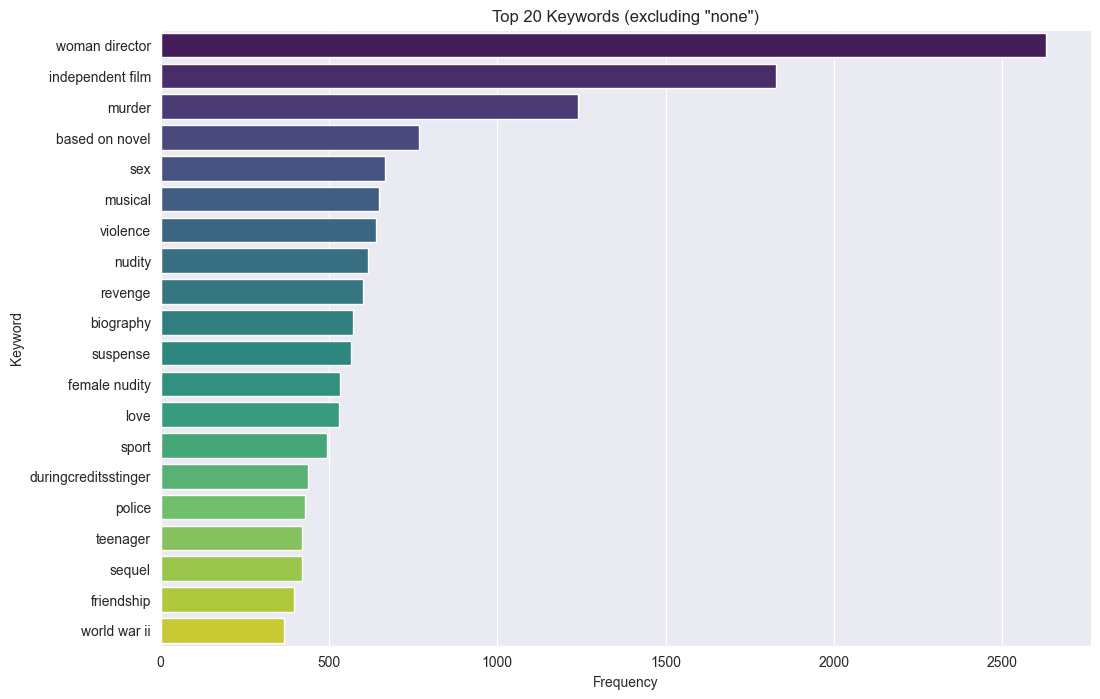

In [42]:
# Plot the top 20 keywords that were assigned to most movies without the 'none' keyword
top_keywords = df_merged['keywords_extracted'].explode().value_counts().head(21)[1:]

plt.figure(figsize=(12, 8))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title('Top 20 Keywords (excluding "none")')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

- The most common keyword is 'woman director' which indicates that many movies are directed by women or that the movie industry is trying to promote diversity OR that consumers are interested in movies directed by women.
- The second most common keyword is 'independent film' which suggests that many movies in the dataset are independent films.
- Overall we can see that the keywords are quite diverse and cover a wide range of topics and themes.

Top 3 Keywords per Genre (ignoring 'none' keyword)

/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_49862/4069899818.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_data, x='keywords_extracted', y='count', ax=axs[i], palette='viridis')
/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_49862/4069899818.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_data, x='keywords_extracted', y='count', ax=axs[i], palette='viridis')
/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_49862/4069899818.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barp

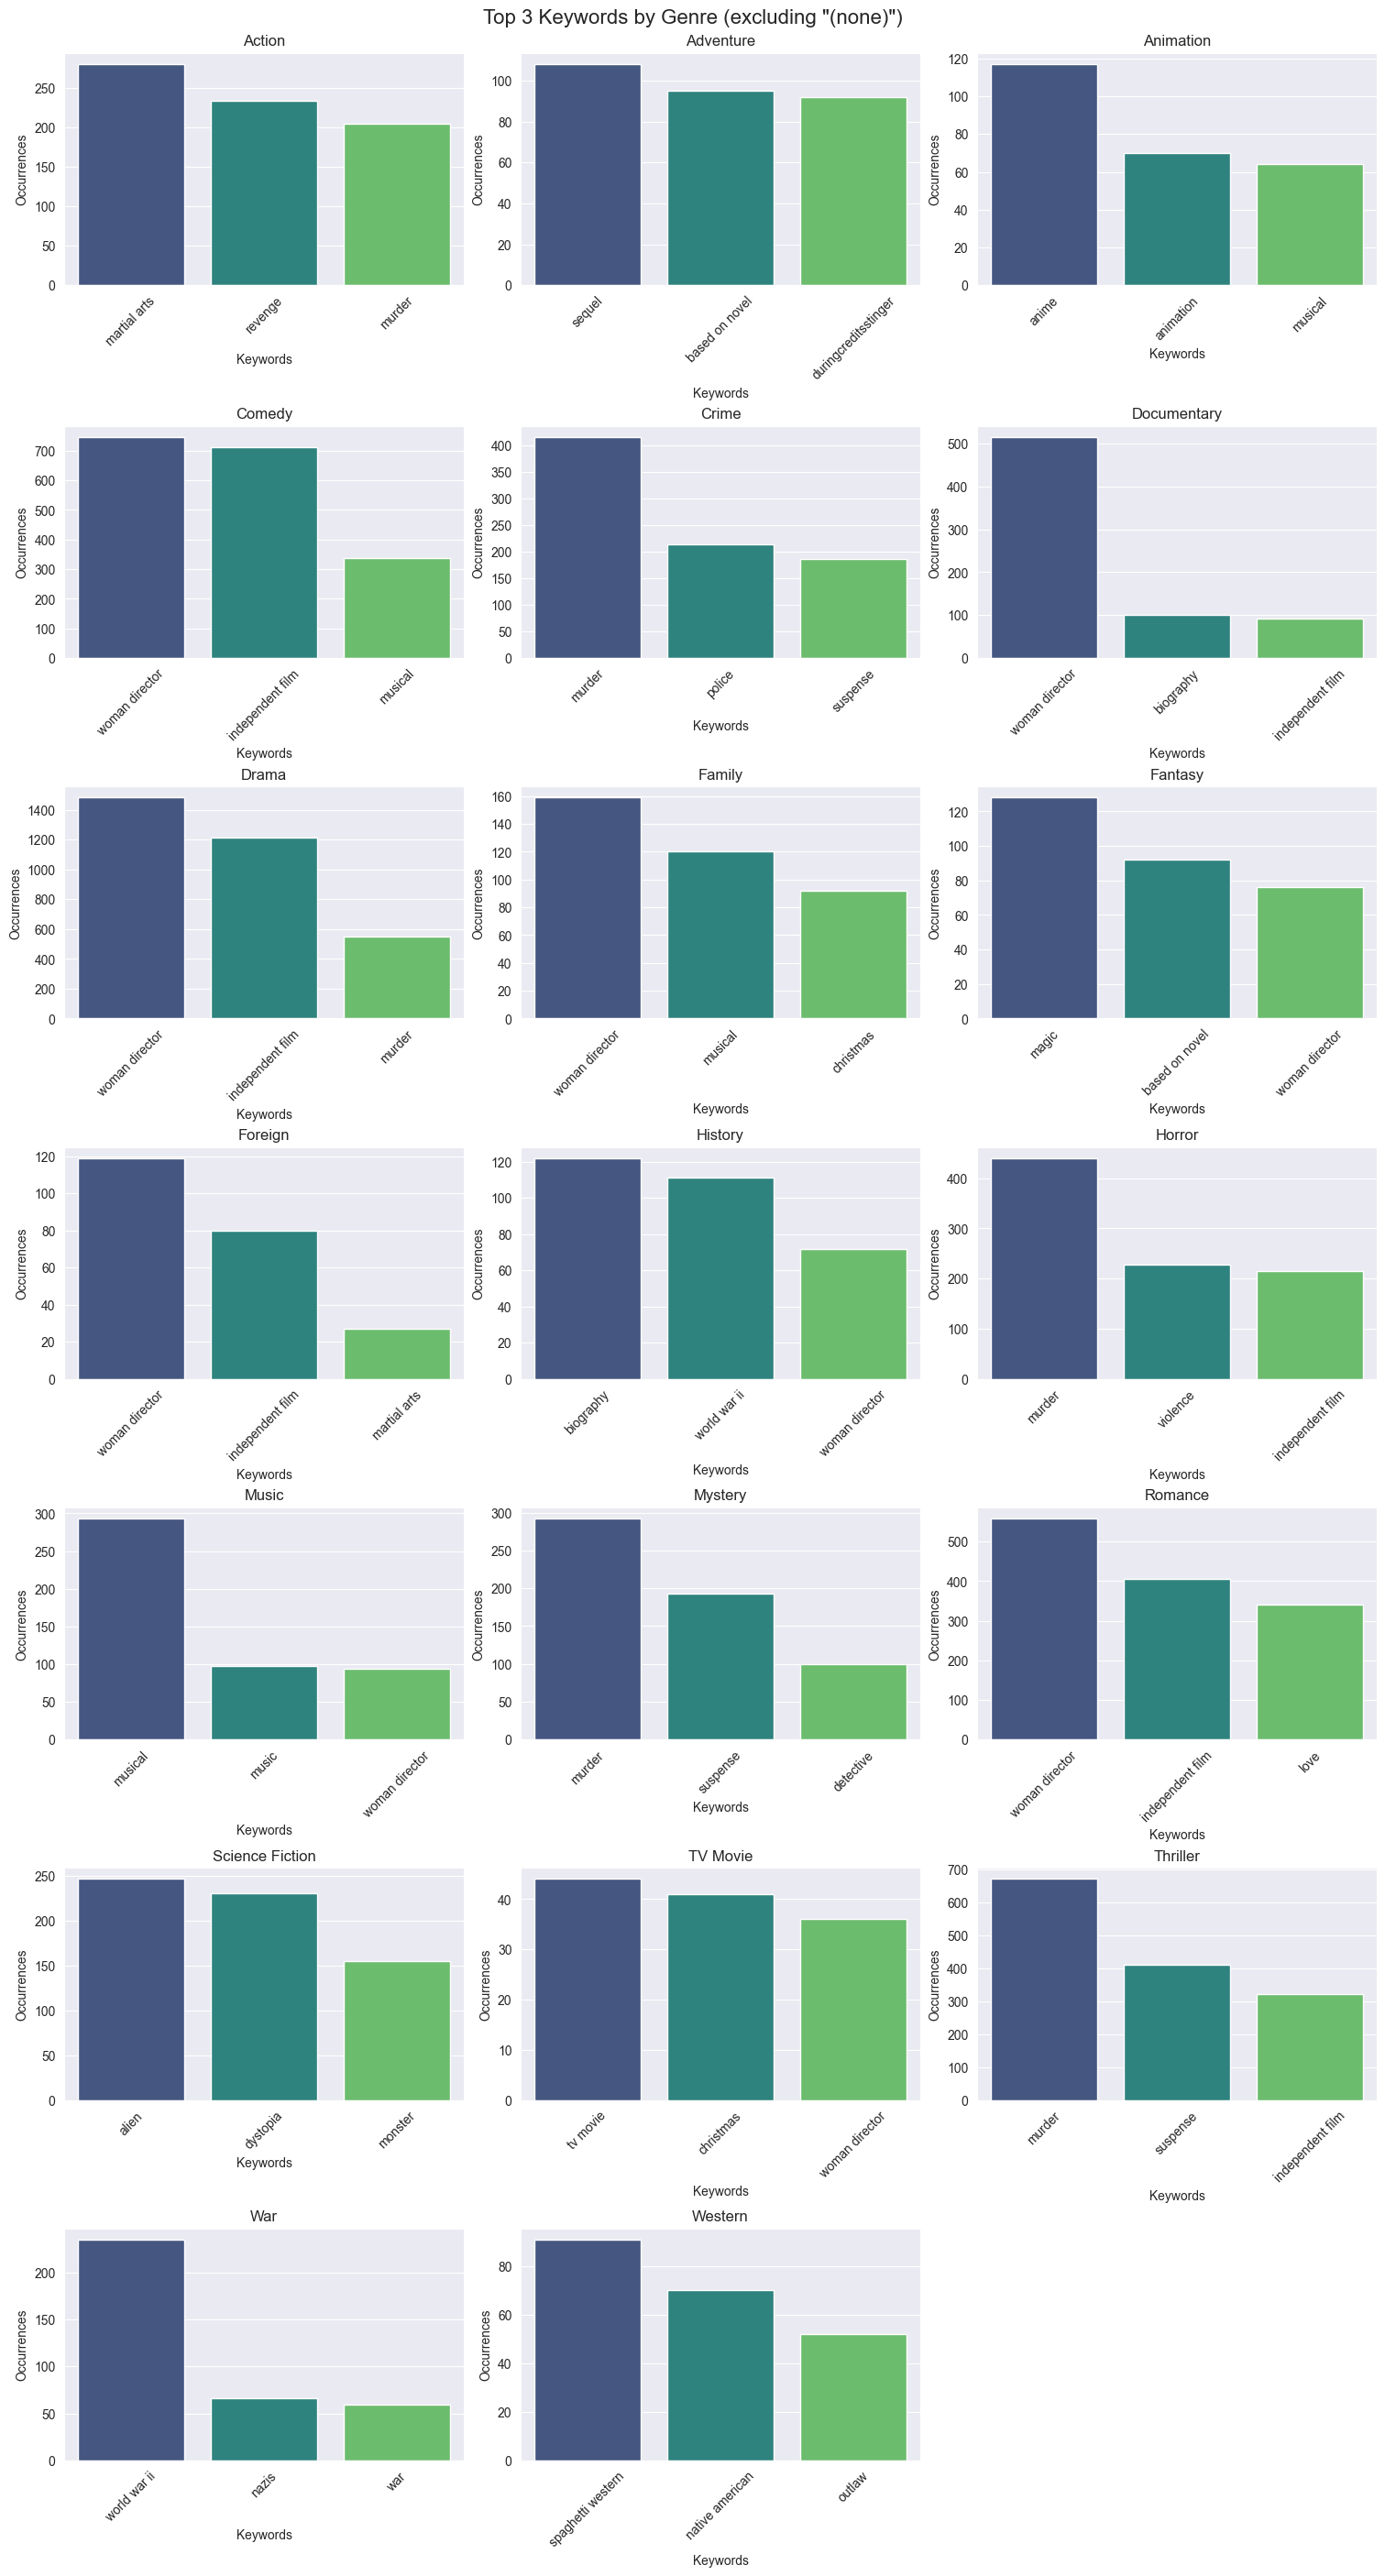

In [43]:
# Filter out rows where 'genre_extracted' is '(none)'
filtered_genre_keywords = df_merged[df_merged['genre_extracted'] != '(none)']

# Explode the DataFrame on the 'genre_extracted' and 'keywords_extracted' columns to have one genre and one keyword per row
filtered_genre_keywords = filtered_genre_keywords.explode('genre_extracted').explode('keywords_extracted')

# Now filter out the pseudo-keyword '(none)' from the keywords
filtered_genre_keywords = filtered_genre_keywords[filtered_genre_keywords['keywords_extracted'] != '(none)']

# Group by genre and keywords, count the occurrences, and get the top 3 for each genre.
top_keywords_by_genre = filtered_genre_keywords.groupby(['genre_extracted', 'keywords_extracted']).size().reset_index(name='count')
top_keywords_by_genre = top_keywords_by_genre.groupby('genre_extracted').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)

# Get a list of unique genres for plotting (excluding '(none)')
unique_genres = top_keywords_by_genre['genre_extracted'].unique()
unique_genres = unique_genres[unique_genres != '(none)'] 

# Determine the layout for the subplots.
n_cols = 3
n_rows = int(np.ceil(len(unique_genres) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)

# Flatten the axes array for easy indexing.
axs = axs.flatten()

for i, genre in enumerate(unique_genres):
    if genre == '(none)':
        continue
    genre_data = top_keywords_by_genre[top_keywords_by_genre['genre_extracted'] == genre]
    sns.barplot(data=genre_data, x='keywords_extracted', y='count', ax=axs[i], palette='viridis')
    axs[i].set_title(f"{genre}")
    axs[i].set_xlabel('Keywords')
    axs[i].set_ylabel('Occurrences')
    axs[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots if the number of genres is not an exact multiple of the layout.
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

plt.suptitle('Top 3 Keywords by Genre (excluding "(none)")', fontsize=16)
plt.show()


- **Consistent Themes**: Certain genres have strong thematic keywords that align with expectations, such as "alien" in Science Fiction and "war" in War.

- **Popular Elements**: Common elements like "love" and "murder" appear across multiple genres, indicating these themes' broad appeal and versatility.

- **Crossover Appeal**: Some keywords suggest a crossover of themes between genres, like "musical" appearing in both Family and Fantasy genres, indicating potential overlap in audience appeal.

- **Woman Director** seems to be a prominent keyword across different genres, indicating a high interest for this. 

Now we do a quick rating comparison for movies with "woman director" keyword and those without:

In [44]:
# Rating Comparison for movies with "woman director" keyword and those without

# Filter the dataframe to create two separate dataframes
movies_with_woman_director = df_merged[df_merged['keywords_extracted'].apply(lambda x: 'woman director' in x)]
movies_without_woman_director = df_merged[df_merged['keywords_extracted'].apply(lambda x: 'woman director' not in x)]

# Merge with ratings dataframe
movies_with_woman_director = movies_with_woman_director.merge(df_ratings, on='movieId')
movies_without_woman_director = movies_without_woman_director.merge(df_ratings, on='movieId')

# Calculate the average rating for each dataframe
avg_rating_with = movies_with_woman_director['rating'].mean()
avg_rating_without = movies_without_woman_director['rating'].mean()

print(f"Average rating for movies with 'woman director' keyword: {avg_rating_with}")
print(f"Average rating for movies without 'woman director' keyword: {avg_rating_without}")

Average rating for movies with 'woman director' keyword: 3.422513530693168
Average rating for movies without 'woman director' keyword: 3.5323066883510275


- The average rating for movies with 'woman director' keyword does not seem to be significantly different from the average rating for movies without. Suggesting that the presence of a female director does not necessarily correlate with the quality of the movie.

## 2.4 Actors

Text(0.5, 0, 'Number of Movies Produced')

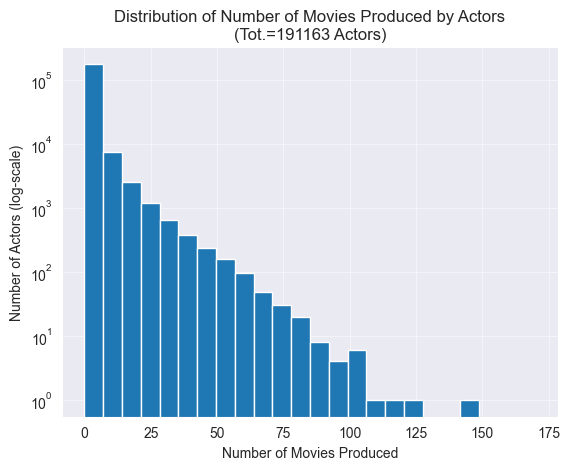

In [45]:
# Show distribution of actors participating in how many films
actors_df = df_merged[['actors']].explode('actors')
actors_df = actors_df.groupby('actors')[['actors']].count()
actors_df.columns = ['count']
actors_df = actors_df.sort_values('count', ascending=False)

fig, ax = plt.subplots()

plt.hist(actors_df, range=(0,170), bins=24)
plt.grid(alpha=.5)
plt.title(f"Distribution of Number of Movies Produced by Actors\n(Tot.={len(actors_df)} Actors)")
plt.yscale('log')
plt.ylabel('Number of Actors (log-scale)')
plt.xlabel('Number of Movies Produced')

The majority of actors have appeared in fewer than 5 films, as indicated by the tall bars on the left. There's a sharp decrease in the number of actors who have appeared in more films, which is characteristic of a "long-tail" distribution. A small number of actors have appeared in up to 120 movies, as shown by the bars to the right, indicating that very few actors have extremely high movie counts.

In [46]:
print("The Top 10 Most Productive Actors in the Dataset are:")
actors_df_10 = actors_df.head(10).reset_index()
actors_df_10.index = range(1,11)
actors_df_10

The Top 10 Most Productive Actors in the Dataset are:


,actors,count
1,Bess Flowers,212
2,Christopher Lee,144
3,John Wayne,123
4,Samuel L. Jackson,118
5,Michael Caine,108
6,Jackie Chan,104
7,Donald Sutherland,103
8,John Carradine,103
9,Frank Welker,101
10,Robert De Niro,101


In [47]:
# Quantiles for 'count' column in actors_df
quantiles = actors_df['count'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

# Create a formatted string for the output
quantile_output = "\n".join([f"{int(quantile * 100)}th percentile: {value:.0f} movie(s)"
                             for quantile, value in quantiles.items()])

print(quantile_output)

10th percentile: 1 movie(s)
25th percentile: 1 movie(s)
50th percentile: 1 movie(s)
75th percentile: 2 movie(s)
90th percentile: 5 movie(s)
95th percentile: 9 movie(s)
99th percentile: 26 movie(s)


90% of actors have appeared in 5 or fewer movies, highlighting a significant concentration of actors with a limited number of appearances. At the high end, the top 1% of actors have been in 26 or more movies, demonstrating a small proportion of actors with extensive filmographies compared to their peers.

## 2.5 Movie Runtime

Text(99, 14000, 'Mean: 100.1 min')

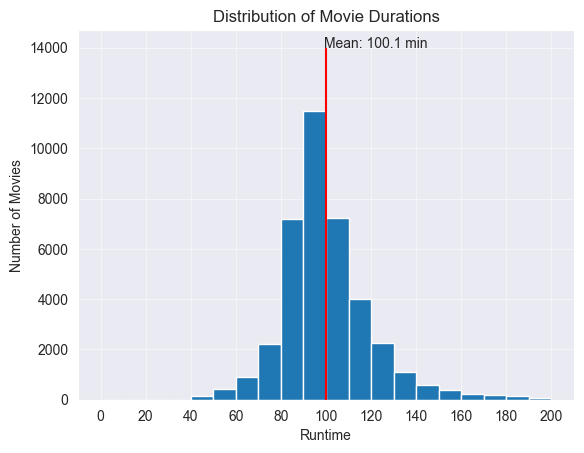

In [48]:
# Distribution of movie runtime
fig, ax = plt.subplots()

plt.hist(df_merged['runtime'], range=(0,200), bins=20)
plt.grid(alpha=.5)
plt.title('Distribution of Movie Durations')
plt.xlabel('Runtime')
plt.ylabel('Number of Movies')
plt.xticks([n*20 for n in range(11)])
plt.vlines(np.mean(df_merged['runtime']), ymin=0, ymax=14000, color='red')
plt.annotate(f"Mean: {round(np.mean(df_merged['runtime']), 1)} min", xy=(99, 14000))

The majority of movies have a runtime around the mean of 100.1 minutes, forming a roughly normal distribution as indicated by the bell shape of the histogram. The tallest bin, signifying the most common runtime range, is centered around the mean, which suggests that most movies in the dataset are close to 100 minutes long.

In [49]:
df_merged["runtime"].describe()

count    38862.000000
mean       100.120426
std         22.656623
min         45.000000
25%         88.000000
50%         96.000000
75%        108.000000
max        300.000000
Name: runtime, dtype: float64

In [50]:
# Show 10 longest movies incl. runtime
ten_longest_movies = df_merged.sort_values(by='runtime', ascending=False)[['title', 'runtime']].head(10)
print(ten_longest_movies)

                           title  runtime
40550                 Wild Palms    300.0
40153        Bytte Bytte Købmand    300.0
17620          Streets of Laredo    300.0
38878   Make Your Own Damn Movie    300.0
44549                 London Spy    300.0
15239                 Wild China    300.0
34989  Musketeers 20 Years Later    300.0
18454                      Judex    300.0
44595            Planet Earth II    300.0
42507        The Way We Live Now    300.0


## 2.6 Production Countries

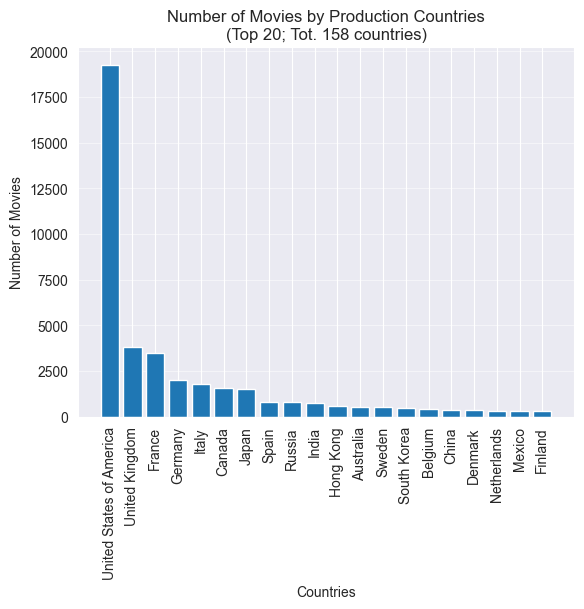

In [51]:
# Show number of movies by production country
countries_df = df_merged[['title', 'production_country_extracted']].explode('production_country_extracted')
countries_df = countries_df.groupby('production_country_extracted')['title'].count().sort_values(ascending=False)
plt.bar(x=countries_df.index[:20], height=countries_df[:20])
plt.title(f"Number of Movies by Production Countries\n(Top 20; Tot. {len(countries_df)} countries)")
plt.grid(axis='y', alpha=.5)
plt.ylabel('Number of Movies')
plt.xlabel('Countries')
plt.xticks(rotation=90);

The US is by far the country with most movies produced, followed by 4 European countries. The first Asian country, Japan, is seventh.

In [52]:
# Top 10 countries that produce the longest movies
exploded_df = df_merged.explode('production_country_extracted')
average_runtime_by_country = exploded_df.groupby('production_country_extracted')['runtime'].mean().sort_values(ascending=False)
print(average_runtime_by_country.head(10))

production_country_extracted
Libyan Arab Jamahiriya    182.666667
Kuwait                    177.000000
India                     141.401894
Malta                     137.875000
Bangladesh                128.500000
Algeria                   127.777778
Belarus                   121.625000
Ghana                     115.750000
Trinidad and Tobago       113.500000
Ethiopia                  113.500000
Name: runtime, dtype: float64


## 2.7 Languages

In [53]:
df_merged.head()

,id_x,movieId,imdbId,tmdbId,belongs_to_collection,original_language,overview,popularity,release_date,runtime,title,vote_average,vote_count,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted,spoken_language_extracted
0,862,1,114709,862,1,en,"Led by Woody, Andy's toys live happily in his ...",21.0,1995-10-30,81.0,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America],[English]
1,8844,2,113497,8844,0,en,When siblings Judy and Peter discover an encha...,17.0,1995-12-15,104.0,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],"[English, Français]"
2,15602,3,113228,15602,1,en,A family wedding reignites the ancient feud be...,11.0,1995-12-22,101.0,Grumpier Old Men,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America],[English]
3,31357,4,114885,31357,0,en,"Cheated on, mistreated and stepped on, the wom...",3.0,1995-12-22,127.0,Waiting to Exhale,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America],[English]
4,11862,5,113041,11862,1,en,Just when George Banks has recovered from his ...,8.0,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America],[English]


In [54]:
# Show number of movies by spoken language
languages_df = df_merged[['title', 'spoken_language_extracted']].explode('spoken_language_extracted')
languages_df = languages_df.groupby('spoken_language_extracted')['title'].count().sort_values(ascending=False)
languages_df

spoken_language_extracted
English            26184
Français            3749
Deutsch             2348
Español             2189
Italiano            1961
                   ...  
беларуская мова        2
Malti                  2
Hausa                  1
Fulfulde               1
ozbek                  1
Name: title, Length: 75, dtype: int64

/Users/maltehaupt/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
/Users/maltehaupt/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  func(*args, **kwargs)
/Users/maltehaupt/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from current font.
  func(*args, **kwargs)
/Users/maltehaupt/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26222 (\N{CJK UNIFIED IDEOGRAPH-666E}) missing from current font.
  func(*args, **kwargs)
/Users/maltehaupt/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from current font.
  func(*args, **kwargs)
/Users/maltehaupt/anaconda3/lib/pyt

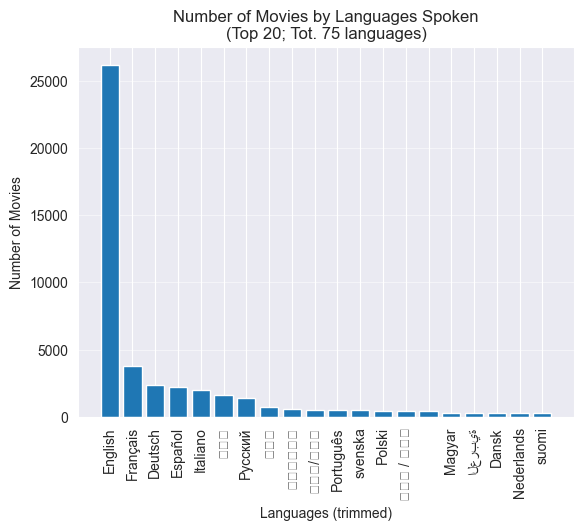

In [55]:
plt.bar(x=languages_df.index[:20], height=languages_df[:20])
plt.title(f"Number of Movies by Languages Spoken\n(Top 20; Tot. {len(languages_df)} languages)")
plt.grid(axis='y', alpha=.5)
plt.ylabel('Number of Movies')
plt.xlabel('Languages (trimmed)')
plt.xticks(rotation=90);

- The most common language is English, followed by French and German.
- The distribution of languages is right-skewed, with English obviously being the most common language and most movies being produced in USA and UK.

We try to find the most common genres per language.

In [56]:
# Explode the 'genre_extracted' column
df_genres_exploded = df_merged.explode('genre_extracted')

# Explode the 'spoken_language_extracted' column
df_languages_exploded = df_merged.explode('spoken_language_extracted')

# Find the top 10 most common genres
top_genres = df_genres_exploded['genre_extracted'].value_counts().nlargest(10).index

# Find the top 10 most common languages
top_languages = df_languages_exploded['spoken_language_extracted'].value_counts().nlargest(10).index

# Filter the exploded DataFrame to only include rows with top genres and top languages
df_filtered = df_merged[df_merged['genre_extracted'].apply(lambda x: any(genre in x for genre in top_genres)) & df_merged['spoken_language_extracted'].apply(lambda x: any(language in x for language in top_languages))]

# Re-explode the filtered DataFrame to prepare for crosstab
df_filtered = df_filtered.explode('genre_extracted')
df_filtered = df_filtered.explode('spoken_language_extracted')

# Cross-tabulate to count the genres within each of the top languages
crosstab_result = pd.crosstab(df_filtered['spoken_language_extracted'], df_filtered['genre_extracted'])

# Get the most common genre for each of the top languages
most_common_genre_per_language = crosstab_result.idxmax(axis=1)

# Display the most common genre for each language
most_common_genre_per_language

spoken_language_extracted
                     Drama
?????                Drama
??????               Drama
Afrikaans            Drama
Bahasa indonesia     Drama
                     ...  
ქართული              Drama
广州话 / 廣州話           Action
日本語                  Drama
普通话                  Drama
한국어/조선말              Drama
Length: 71, dtype: object

- The most common genre overall is Drama
- The column 'spoken_language_extracted' contains languages in their original names, which could be cleaned up for better analysis.

It also contains a language called Esperanto which is a constructed international auxiliary language, which was designed to have a simple and regular grammar, with a vocabulary primarily derived from Romance and Germanic language roots see https://en.wikipedia.org/wiki/Esperanto#:~:text=Esperanto%20(%2F%CB%8C%C9%9Bsp,%22%20(la%20Lingvo%20Internacia)

We will drop the column 'spoken_language_extracted' as it is not relevant for our analysis and it contains a lot of sparse data. Additionally, the column is kind of uniform with most movies being in English.

In [57]:
df_merged.drop(['spoken_language_extracted'], axis=1, inplace=True)

## 2.8 Conclusion

- **Completeness**: The dataset is quite comprehensive and all adjustments to missing values, outliers etc. have been made. It contains a lot of ratings, crucial for collaborative filtering algorithms.
- **Consistency**: The data is consistent and well-structured, with no apparent inconsistencies or contradictions.
- **Correctness**: The data appears to be correct and accurate, with no obvious errors or biases.
- **Uniqueness**: The dataset is unique and values represent distinct movies, genres, actors, etc.
- **Timeliness**: The dataset is up-to-date as of September 2017, which is sufficient for our analysis and model development. However, it is always beneficial to have the most recent data available, which could be a limitation.
- **Stability**: The dataset is stable and unlikely to change over time, as it is historical data that does not require frequent updates. The source is reliable and so is the data is comparable among sources over time.
- **Relevance**: The dataset contains a wide variety of movies, genres, and keywords, making it highly relevant for our business case to develop a high quality recommendation system.
- **Contextualization**: The dataset is well-organized and structured, making it easy to understand and analyze. The columns are clearly labeled and the data is presented in a logical manner, including annotations and explanations where necessary.
- **Trustworthiness**: The dataset is from a reputable source, The Movie Database (TMDb), which is a popular movie and TV show database. The data is likely to be accurate and reliable.

The dataset is suitable for a hybrid recommendation approach that combines content-based and collaborative filtering methods. The diverse range of genres and the detailed user ratings can be used to create personalized recommendations, while the large number of ratings can be used to find similar users and movies for collaborative filtering.

Some potential challenges include handling sparse data in the 'keywords_extracted' column and dealing with the long-tail distribution of actors and genres. These challenges can be addressed through feature engineering to improve the quality of recommendations.

All insights learned from the EDA are valuable in the next step of building the features for the model training.

In [61]:
# Save the cleaned datasets
df_ratings.to_pickle('data/df_ratings_cleaned.pkl')
df_merged.to_pickle('data/df_movies_cleaned.pkl')